In [54]:
import zipfile
import os

# Define the paths
zip_file_path = './test_images.zip'  # Update with your ZIP file path
extract_to_dir = '.'  # Update with your extraction directory

# Create the directory if it does not exist
os.makedirs(extract_to_dir, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

print("Extraction completed.")


Extraction completed.


In [49]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('Test_classes.csv')

# Replace 'your_column_name' with the actual column name
df['label'] = df['label'].str.split('_').str[0]

# Save the updated DataFrame to a new CSV (optional)
df.to_csv('updated_test_file.csv', index=False)

print(df.head())  # Preview the changes


                                       image_id  x_min  y_min  x_max  y_max  \
0  coco_gtsd_cycle1/imgs/78000_000000458168.jpg    819    447    874    502   
1  coco_gtsd_cycle1/imgs/78001_000000237443.jpg      0    429    157    569   
2  coco_gtsd_cycle1/imgs/78002_000000163608.jpg    481    488    549    549   
3  coco_gtsd_cycle1/imgs/78002_000000163608.jpg    983    728   1053    793   
4  coco_gtsd_cycle1/imgs/78003_000000161746.jpg    995      0   1197    200   

  label  
0    15  
1    21  
2    31  
3    21  
4    17  


In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import mobilenet_v2
from PIL import Image
import os
import pandas as pd

# Define the Traffic Sign Dataset
class TrafficSignDataset(Dataset):
    def __init__(self, img_folder, csv_file, transform=None):
        self.img_folder = img_folder
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations['image_id'].unique())

    def __getitem__(self, idx):
        # Load image
        img_id = self.annotations['image_id'].unique()[idx]
        img_id = os.path.basename(img_id)  # Extract the actual image filename
        img_path = os.path.join(self.img_folder, img_id)
        image = Image.open(img_path).convert("RGB")
        
        # Filter annotations for the current image
        img_x='coco_gtsd_cycle1/imgs/'+img_id
        image_annotations = self.annotations[self.annotations['image_id'] == img_x]
        # Extract bounding boxes and labels
        boxes = image_annotations[['x_min', 'y_min', 'x_max', 'y_max']].values
        labels = image_annotations['label'].astype(int).values
        
        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        # Transform image
        if self.transform:
            image = self.transform(image)
        
        # Create target dictionary
        target = {
            'boxes': boxes,
            'labels': labels
        }
        return image, target

# Transform for the dataset


In [39]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Dataset paths
img_folder = "./train_images"
csv_file = "./updated_file.csv"
dataset = TrafficSignDataset(img_folder, csv_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [11]:
import torch
import torch.nn as nn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import mobilenet_v2
import torchvision

class MobileNetBackbone(nn.Module):
    def __init__(self, mobilenet):
        super().__init__()
        # Extract layers up to the final convolution
        self.features = nn.Sequential(*list(mobilenet.features.children()))
        self.out_channels = 1280  # Output channels of the final layer

    def forward(self, x):
        # Only output the last layer
        feature = self.features(x)
        return {"0": feature}

def create_model(num_classes):
    # Load MobileNetV2 backbone
    mobilenet = mobilenet_v2(pretrained=True)
    backbone = MobileNetBackbone(mobilenet)

    # RPN anchor generator
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),  # 5 pyramid levels
        aspect_ratios=((0.5, 1.0, 2.0),)  # 1 aspect ratio tuple for each level
    )

    # RoI pooling
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=["0"],  # Backbone feature map names (use the first level)
        output_size=7,        # Output size of the RoI Align
        sampling_ratio=2      # Sampling ratio for RoI Align
    )

    # Faster R-CNN model
    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )
    return model

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
# Create the model
num_classes = 43  # Adjust based on your dataset
model = create_model(num_classes).to(device)

# Print model summary for verification
print(model)

cpu


C:\Users\bagaw\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\bagaw\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): MobileNetBackbone(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, 

In [47]:
# Training Function
def train_model(model, dataloader, num_epochs=5, learning_rate=0.005):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, targets in dataloader:
            # Move images and targets to device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values() if not torch.isnan(loss))
            epoch_loss += losses.item()

            # Backward pass
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Train the model
train_model(model, dataloader, num_epochs=25, learning_rate=0.005)


Epoch [1/25], Loss: 4.8832
Epoch [2/25], Loss: 4.8552
Epoch [3/25], Loss: 4.8560
Epoch [4/25], Loss: 4.7910
Epoch [5/25], Loss: 4.5175
Epoch [6/25], Loss: 4.6316
Epoch [7/25], Loss: 4.6716
Epoch [8/25], Loss: 4.5633
Epoch [9/25], Loss: 4.6762
Epoch [10/25], Loss: 4.3846
Epoch [11/25], Loss: 4.2756
Epoch [12/25], Loss: 4.0885
Epoch [13/25], Loss: 4.4380
Epoch [14/25], Loss: 4.1769
Epoch [15/25], Loss: 3.9785
Epoch [16/25], Loss: 3.9503
Epoch [17/25], Loss: 3.8437
Epoch [18/25], Loss: 3.7656
Epoch [19/25], Loss: 4.0295
Epoch [20/25], Loss: 3.7324
Epoch [21/25], Loss: 3.7112
Epoch [22/25], Loss: 3.8605
Epoch [23/25], Loss: 3.5955
Epoch [24/25], Loss: 3.6592
Epoch [25/25], Loss: 3.6764


In [48]:
torch.save(model.state_dict(), "mobilenet_frcnn.pth")

In [55]:
img_folder = "./test_images"
csv_file = "./updated_test_file.csv"
dataset1 = TrafficSignDataset(img_folder, csv_file, transform=transform)
test_dataloader = DataLoader(dataset1, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [58]:
import numpy as np
def calculate_ap_per_class(pred_boxes, pred_scores, pred_labels, true_boxes, true_labels, iou_threshold=0.5, num_classes=3):
    """
    Calculate the Average Precision (AP) for each class.
    """
    ap_per_class = []

    for cls in range(1, num_classes):  # Exclude background class (class 0)
        cls_pred_boxes = []  # Initialize as a list
        cls_pred_scores = []  # Initialize as a list
        cls_true_boxes = []  # Initialize as a list

        # Filter predictions and ground truth for the current class
        for p_boxes, p_scores, p_labels, t_boxes, t_labels in zip(pred_boxes, pred_scores, pred_labels, true_boxes, true_labels):
            cls_pred_boxes.append(p_boxes[p_labels == cls])  # Append NumPy arrays for current class
            cls_pred_scores.append(p_scores[p_labels == cls])
            cls_true_boxes.append(t_boxes[t_labels == cls])

        # Flatten lists
        cls_pred_boxes = np.concatenate(cls_pred_boxes, axis=0) if cls_pred_boxes else np.empty((0, 4))
        cls_pred_scores = np.concatenate(cls_pred_scores, axis=0) if cls_pred_scores else np.empty((0,))
        cls_true_boxes = np.concatenate(cls_true_boxes, axis=0) if cls_true_boxes else np.empty((0, 4))

        # Sort predictions by score (descending)
        sorted_indices = np.argsort(-cls_pred_scores)
        cls_pred_boxes = cls_pred_boxes[sorted_indices]
        cls_pred_scores = cls_pred_scores[sorted_indices]

        # Match predictions to ground truth
        true_positives = np.zeros(len(cls_pred_boxes))
        false_positives = np.zeros(len(cls_pred_boxes))
        matched_gt = set()

        for i, pred_box in enumerate(cls_pred_boxes):
            if len(cls_true_boxes) == 0:
                false_positives[i] = 1
                continue

            # Compute IoU with all ground truth boxes
            ious = box_iou(torch.tensor([pred_box]), torch.tensor(cls_true_boxes)).numpy()[0]

            # Find the best match (if IoU exceeds threshold)
            best_iou_idx = np.argmax(ious)
            best_iou = ious[best_iou_idx]

            if best_iou >= iou_threshold and best_iou_idx not in matched_gt:
                true_positives[i] = 1
                matched_gt.add(best_iou_idx)
            else:
                false_positives[i] = 1

        # Calculate precision and recall
        tp_cumsum = np.cumsum(true_positives)
        fp_cumsum = np.cumsum(false_positives)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-7)
        recalls = tp_cumsum / (len(cls_true_boxes) + 1e-7)

        # Compute AP (area under the precision-recall curve)
        ap = auc(recalls, precisions) if len(recalls) > 0 else 0
        ap_per_class.append(ap)

    return ap_per_class


In [59]:
from torchvision.ops import box_iou
from sklearn.metrics import precision_recall_curve, auc


def test_model(model, dataloader, device, num_classes=3, iou_threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    all_pred_boxes = []
    all_pred_labels = []
    all_pred_scores = []
    all_true_boxes = []
    all_true_labels = []

    with torch.no_grad():  # No gradients needed during testing
        for images, targets in dataloader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass through the model
            outputs = model(images)

            # Collect predictions and ground truths for all images in the batch
            for output, target in zip(outputs, targets):
                all_pred_boxes.append(output['boxes'].cpu().numpy())
                all_pred_labels.append(output['labels'].cpu().numpy())
                all_pred_scores.append(output['scores'].cpu().numpy())

                all_true_boxes.append(target['boxes'].cpu().numpy())
                all_true_labels.append(target['labels'].cpu().numpy())

    # Calculate AP for each class
    ap_per_class = calculate_ap_per_class(
        all_pred_boxes, all_pred_scores, all_pred_labels, 
        all_true_boxes, all_true_labels, 
        iou_threshold, num_classes
    )
    
    # Mean Average Precision (mAP)
    mean_ap = np.mean(ap_per_class)
    
    print(f"AP per class: {ap_per_class}")
    print(f"Mean Average Precision (mAP) on the test set: {mean_ap:.4f}")

    return ap_per_class, mean_ap


# Example of how to use the testing function:
ap_per_class, mean_ap = test_model(model, test_dataloader, device, num_classes=43)


AP per class: [0.8717391649208829, 0.8509275955277777, 0.9424050217349786, 0.9358215436910312, 0.8451854736679073, 0.8981249071514539, 0.9325712710242186, 0.9293488953771625, 0.9435530804372997, 0.9180661003184045, 0.8798491915326767, 0.9292087851992739, 0.9144377667182866, 0.9480136206392372, 0.9398053069713217, 0.951647302799626, 0.9387849231307992, 0.915735263804217, 0.9135920001903736, 0.8653271463167135, 0.8805316811005316, 0.9320687210463745, 0.862007290672237, 0.8760276197846506, 0.910212246208129, 0.8990938138674207, 0.8619906339642823, 0.8305623987485101, 0.892757992402626, 0.883849513324589, 0.9199878082473948, 0.963837901634504, 0.9481836037080071, 0.9348104265237311, 0.9731130776828721, 0.9241461402061371, 0.9555994912322422, 0.960699557466906, 0.9386550119975821, 0.9474305695694686, 0.9028067036164046, 0.9229823118326468]
Mean Average Precision (mAP) on the test set: 0.9139


In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import mobilenet_v2
from PIL import Image
import os
import pandas as pd

In [3]:
from PIL import Image
import torch
from torchvision.transforms import functional as F

# Load the trained model
def load_trained_model(model_path, num_classes):
    # Initialize the model
    model = create_model(num_classes)
    # Load the trained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image and convert to RGB
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    return transform(image)  # [C, H, W]


In [6]:

# Post-process and display predictions
def postprocess_predictions(predictions, threshold=0.5):
    boxes = predictions['boxes'].cpu().detach().numpy()
    scores = predictions['scores'].cpu().detach().numpy()
    labels = predictions['labels'].cpu().detach().numpy()

    # Filter results based on threshold
    selected_indices = scores >= threshold
    filtered_boxes = boxes[selected_indices]
    filtered_scores = scores[selected_indices]
    filtered_labels = labels[selected_indices]

    return filtered_boxes, filtered_scores, filtered_labels



In [7]:
# Inference function
def predict_single_image(model, image_path, threshold=0.5):
    # Preprocess the image
    image = preprocess_image(image_path)  # [C, H, W]
    image = image.to(device)

    # Make predictions
    with torch.no_grad():
        predictions = model([image])[0]  # Pass the image as a list
        print(predictions)
    # Post-process predictions
    boxes, scores, labels = postprocess_predictions(predictions, threshold)

    return boxes, scores, labels

In [8]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left',
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(image_path, boxes, scores, labels):
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()
    for box, score, label in zip(boxes, scores, labels):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min - 10, f"Class: {classes[label]}, Score: {score:.2f}", color='red', fontsize=12, backgroundcolor='white')
    plt.show()



C:\Users\bagaw\AppData\Local\Temp\ipykernel_5176\1412376680.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

{'boxes': tensor([[  14.5836, 1015.5743,  187.9450, 1179.4283],
        [  14.9279,  864.0303,  175.1021, 1006.7266],
        [  23.0597,  889.6028,  185.8219, 1142.5135],
        [  19.7561,  864.8833,  178.4637, 1001.8261]]), 'labels': tensor([40, 19, 23, 31]), 'scores': tensor([0.9992, 0.9576, 0.1023, 0.0656])}


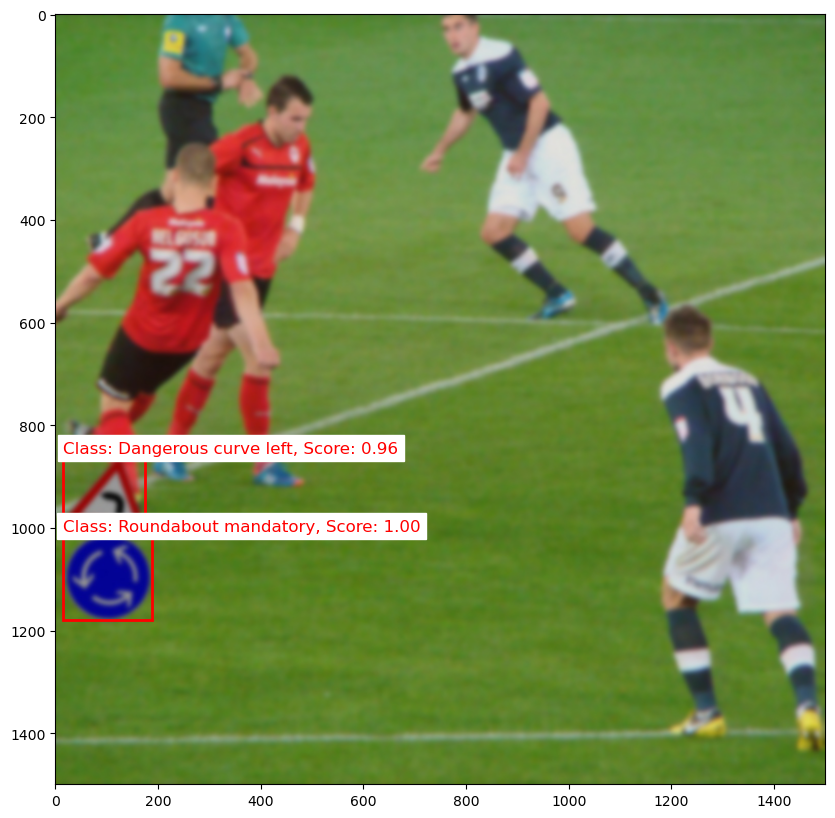

Predicted Boxes: [[  14.583621 1015.57434   187.94502  1179.4283  ]
 [  14.927853  864.0303    175.1021   1006.72656 ]]
Scores: [0.999243   0.95762223]
Labels: [40 19]


In [12]:

# Example usage
model_path = "mobilenet_frcnn.pth"  # Path to the saved model weights
num_classes = 43  # Update this based on your dataset
image_path = "./img.jpg"  # Path to the test image
threshold = 0.6 # Confidence threshold

# Load model
model = load_trained_model(model_path, num_classes).to(device)

# Perform inference
boxes, scores, labels = predict_single_image(model, image_path, threshold)
visualize_predictions(image_path, boxes, scores, labels)
# Print the results
print("Predicted Boxes:", boxes)
print("Scores:", scores)
print("Labels:", labels)